
# FIAP — Fase 3, Capítulo 1 — *Opção 2: Machine Learning no Agronegócio*  
**Autor:** Murilo Salla (RM568041)

Este notebook consolida **todas as entregas** exigidas:
- ✅ Análise Exploratória (≥ 5 gráficos)
- ✅ Identificação do *perfil ideal* (solo/clima) para **milho, soja e café**
- ✅ Desenvolvimento de **5 modelos preditivos**
- ✅ Avaliação **comparativa** dos modelos
- ✅ Geração dos **prints** em `assets/` para evidência

> **Base utilizada:** `data/fase2_sensores_20251025_084829.csv`  
> (equivalente conceitual ao *produtos_agricolas.csv* do enunciado)


## 1) Setup do ambiente

In [9]:

# Se estiver rodando localmente e precisar instalar dependências no ambiente do Jupyter:
# !pip install pandas==2.2.3 matplotlib==3.9.2 seaborn==0.13.2 scikit-learn==1.5.2

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Diretórios
ASSETS_DIR = "assets"
DATA_PATH = "data/fase2_sensores_20251025_084829.csv"
os.makedirs(ASSETS_DIR, exist_ok=True)

print(f'[OK] Assets dir: {ASSETS_DIR}')
print(f'[OK] Data path: {DATA_PATH} (ajuste se necessário)')


[OK] Assets dir: assets
[OK] Data path: data/fase2_sensores_20251025_084829.csv (ajuste se necessário)


## 2) Carregar base

In [10]:

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


(57, 16)


,row_id,umidade_pct,temp_c,ldr,ph_sim,ph_ok,n_ok,p_ok,k_ok,faltando,limiar_on,limiar_off,rain_mm,pop_pct,irrigacao,source_file
0,1,43.0,24.0,1979,6.77,SIM,0,0,0,3,44.0,49.0,0.0,0,DESLIGADA,Log Wokwi.txt
1,2,43.0,24.0,1979,6.77,SIM,0,0,0,3,44.0,49.0,0.0,0,DESLIGADA,Log Wokwi.txt
2,3,43.0,24.0,1979,6.77,SIM,0,0,0,3,44.0,49.0,0.0,0,LIGADA,Log Wokwi.txt
3,4,43.0,24.0,1979,6.77,SIM,0,0,0,3,44.0,49.0,0.0,0,LIGADA,Log Wokwi.txt
4,5,43.0,24.0,1979,6.77,SIM,0,0,0,3,44.0,49.0,0.0,0,LIGADA,Log Wokwi.txt


## 3) EDA — Análise Exploratória (≥5 gráficos)

,umidade_pct,temp_c,ph_sim,rain_mm
count,57.000000,57.000000,57.000000,57.0
mean,38.885965,24.322807,7.412281,0.0
std,9.697670,15.421078,2.936034,0.0
min,15.500000,-25.300000,0.240000,0.0
25%,36.000000,26.700000,6.770000,0.0
50%,36.000000,26.700000,6.770000,0.0
75%,43.000000,26.700000,8.440000,0.0
max,84.500000,69.200000,13.640000,0.0


<Figure size 1000x600 with 0 Axes>

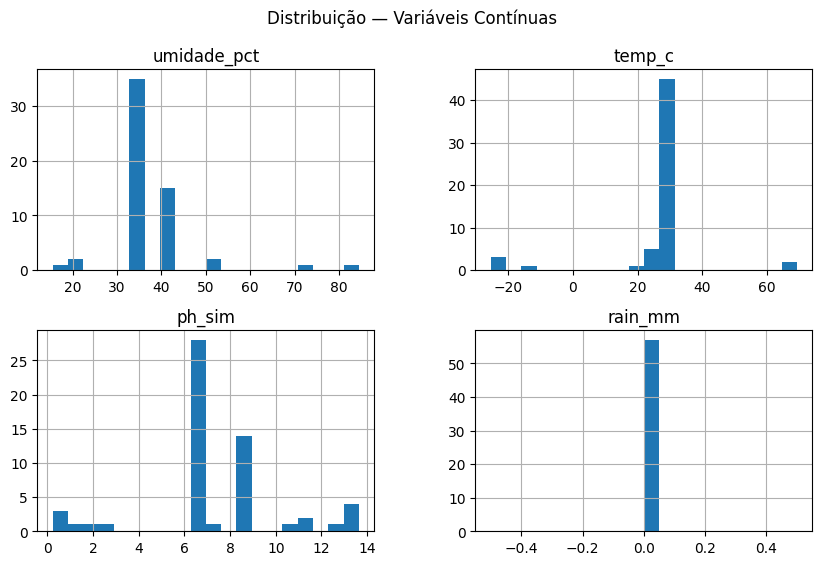

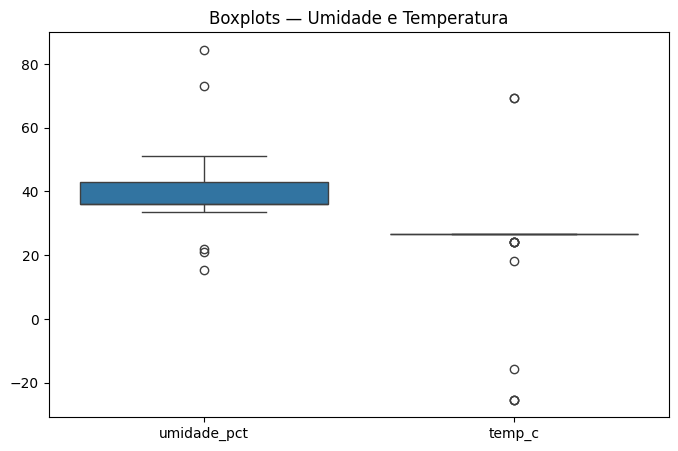

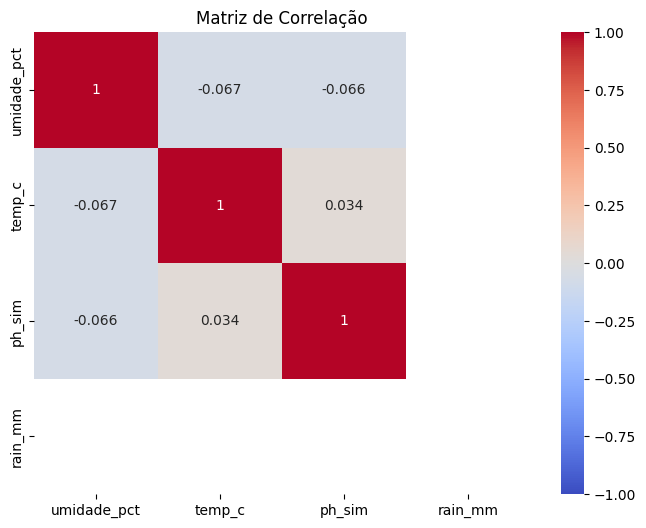

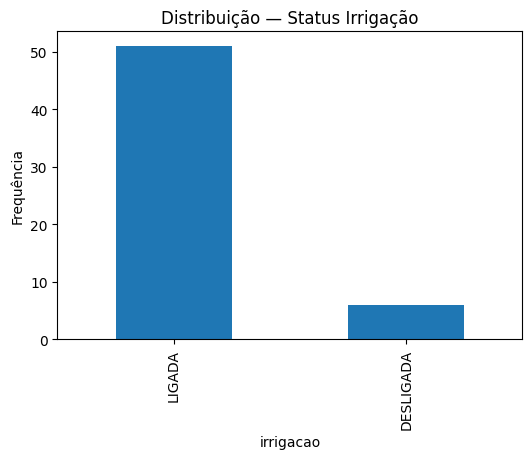

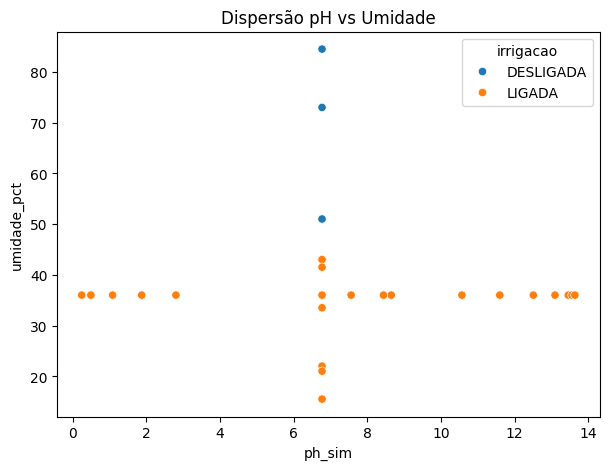

In [11]:

cont_vars = ["umidade_pct", "temp_c", "ph_sim", "rain_mm"]
display(df[cont_vars].describe())

# 1) Histogramas
fig = plt.figure(figsize=(10,6))
df[cont_vars].hist(bins=20, layout=(2,2), figsize=(10,6))
plt.suptitle("Distribuição — Variáveis Contínuas")
plt.savefig(f"{ASSETS_DIR}/eda_histogramas.png", dpi=130, bbox_inches="tight")
plt.show()

# 2) Boxplots (umidade e temperatura)
plt.figure(figsize=(8,5))
sns.boxplot(data=df[["umidade_pct","temp_c"]])
plt.title("Boxplots — Umidade e Temperatura")
plt.savefig(f"{ASSETS_DIR}/eda_boxplots.png", dpi=130, bbox_inches="tight")
plt.show()

# 3) Correlação
plt.figure(figsize=(8,6))
sns.heatmap(df[cont_vars].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de Correlação")
plt.savefig(f"{ASSETS_DIR}/eda_correlacao.png", dpi=130, bbox_inches="tight")
plt.show()

# 4) Distribuição do status de irrigação
plt.figure(figsize=(6,4))
df["irrigacao"].value_counts().plot(kind="bar")
plt.title("Distribuição — Status Irrigação")
plt.ylabel("Frequência")
plt.savefig(f"{ASSETS_DIR}/eda_irrigacao.png", dpi=130, bbox_inches="tight")
plt.show()

# 5) Dispersão pH vs Umidade (colorido por irrigação)
plt.figure(figsize=(7,5))
sns.scatterplot(x="ph_sim", y="umidade_pct", hue="irrigacao", data=df)
plt.title("Dispersão pH vs Umidade")
plt.savefig(f"{ASSETS_DIR}/eda_ph_umidade.png", dpi=130, bbox_inches="tight")
plt.show()


## 4) Perfis ideais (solo/clima) e rotulagem sintética

In [12]:

# Perfis ideais (faixas) — milho, soja, café (sintéticos porém plausíveis)
PERFIS = {
    "milho": {
        "umidade_pct": (45, 65),
        "temp_c": (24, 30),
        "ph_sim": (5.5, 7.0),
        "rain_mm": (2, 20),
    },
    "soja": {
        "umidade_pct": (50, 70),
        "temp_c": (22, 28),
        "ph_sim": (6.0, 7.5),
        "rain_mm": (2, 25),
    },
    "cafe": {
        "umidade_pct": (60, 80),
        "temp_c": (18, 24),
        "ph_sim": (5.0, 6.5),
        "rain_mm": (5, 30),
    },
}
FEATURES = ["umidade_pct", "temp_c", "ph_sim", "rain_mm"]

def _range_distance(val, low, high):
    if pd.isna(val): 
        return 1.0
    if val < low:
        return (low - val) / max(high - low, 1e-6)
    if val > high:
        return (val - high) / max(high - low, 1e-6)
    return 0.0

def score_row_to_profile(row, perfil):
    dists = []
    for col in FEATURES:
        lo, hi = perfil[col]
        dists.append(_range_distance(row[col], lo, hi))
    # bônus leve por nutrientes OK, quando existir
    bonus = 0.0
    for f in ["n_ok","p_ok","k_ok"]:
        if f in row and str(row[f]).upper() in ("1","SIM","TRUE"):
            bonus -= 0.03
    return max(0.0, np.mean(dists) + bonus)

def assign_label_row(row):
    scores = {cult: score_row_to_profile(row, PERFIS[cult]) for cult in PERFIS}
    return min(scores, key=scores.get)

# Relatório dos perfis
with open(f"{ASSETS_DIR}/ml_perfis_ideais.txt","w",encoding="utf-8") as f:
    f.write("=== Perfis ideais (faixas) — milho, soja, café ===\n\n")
    for cult, ranges in PERFIS.items():
        f.write(f"[{cult.upper()}]\n")
        for k,(lo,hi) in ranges.items():
            f.write(f" - {k}: {lo} a {hi}\n")
        f.write("\n")

# Estatísticas da base nas features
with open(f"{ASSETS_DIR}/ml_perfis_estatisticas_base.txt","w",encoding="utf-8") as f:
    f.write("=== Estatísticas descritivas — base Fase 2 ===\n\n")
    f.write(df[FEATURES].describe().to_string())

# Rotulagem sintética
df_label = df.copy()
df_label["label"] = df_label.apply(assign_label_row, axis=1)
df_label.to_csv(f"{ASSETS_DIR}/fase2_sensores_rotulado.csv", index=False, encoding="utf-8")

counts = df_label["label"].value_counts()
with open(f"{ASSETS_DIR}/ml_perfis_rotulos_sinteticos.txt","w",encoding="utf-8") as f:
    f.write("=== Distribuição de rótulos sintéticos ===\n\n")
    f.write(counts.to_string())

counts


label
soja     32
milho    25
Name: count, dtype: int64

## 5) Modelagem — 5 algoritmos e avaliação comparativa

In [13]:

# Dataset para modelagem
model_df = df_label.copy()

# Seleção e preparação de features
use_cols = ["umidade_pct","temp_c","ph_sim","rain_mm","n_ok","p_ok","k_ok"]
use_cols = [c for c in use_cols if c in model_df.columns]  # só usa o que existe
X = model_df[use_cols].apply(pd.to_numeric, errors="coerce")
X = X.fillna(X.median(numeric_only=True))

y = model_df["label"].astype("category")

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42, stratify=y
)

models = {
    "LogisticRegression": Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=200))]),
    "SVC": Pipeline([("scaler", StandardScaler()), ("clf", SVC(probability=True))]),
    "RandomForest": RandomForestClassifier(n_estimators=250, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "KNN": Pipeline([("scaler", StandardScaler()), ("clf", KNeighborsClassifier(n_neighbors=5))]),
}

rows = []
best_name = None
best_f1 = -1.0
best_pred = None

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    bal = balanced_accuracy_score(y_test, y_pred)

    rows.append({"modelo": name, "accuracy": acc, "macro_f1": f1m, "balanced_acc": bal})

    # relatório individual
    with open(f"{ASSETS_DIR}/ml_{name}_report.txt","w",encoding="utf-8") as f:
        f.write(f"== {name} ==\n")
        f.write(f"Accuracy: {acc:.4f}\nMacro-F1: {f1m:.4f}\nBalanced Acc: {bal:.4f}\n\n")
        f.write(classification_report(y_test, y_pred))

    if f1m > best_f1:
        best_f1 = f1m
        best_name = name
        best_pred = y_pred

report = pd.DataFrame(rows).sort_values("macro_f1", ascending=False)
report.to_csv(f"{ASSETS_DIR}/ml_model_report.csv", index=False, float_format="%.4f")
report


,modelo,accuracy,macro_f1,balanced_acc
0,LogisticRegression,1.00,1.000000,1.000000
2,RandomForest,1.00,1.000000,1.000000
3,GradientBoosting,1.00,1.000000,1.000000
4,KNN,1.00,1.000000,1.000000
1,SVC,0.85,0.849624,0.863636


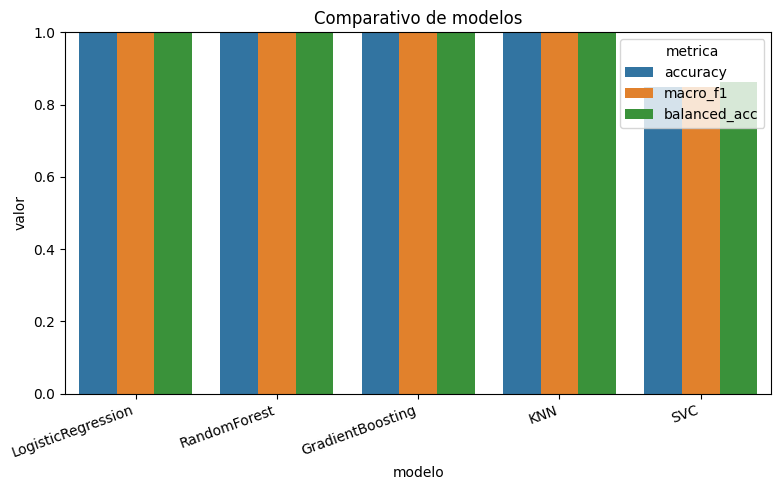

In [14]:

# Gráfico comparativo
plt.figure(figsize=(8,5))
report_m = report.melt(id_vars="modelo", value_vars=["accuracy","macro_f1","balanced_acc"],
                       var_name="metrica", value_name="valor")
sns.barplot(data=report_m, x="modelo", y="valor", hue="metrica")
plt.ylim(0,1.0)
plt.title("Comparativo de modelos")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.savefig(f"{ASSETS_DIR}/ml_model_comparativo.png", dpi=150, bbox_inches="tight")
plt.show()


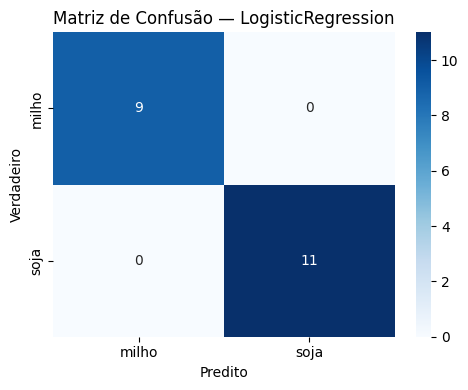

[FINALIZADO] Melhor modelo: LogisticRegression


In [16]:

# Matriz de confusão do melhor
labels = sorted(y.unique())
cm = confusion_matrix(y_test, best_pred, labels=labels)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predito"); plt.ylabel("Verdadeiro")
plt.title(f"Matriz de Confusão — {best_name}")
plt.tight_layout()
plt.savefig(f"{ASSETS_DIR}/ml_best_confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

with open(f"{ASSETS_DIR}/ml_best_classification_report.txt","w",encoding="utf-8") as f:
    f.write(f"=== Melhor modelo: {best_name} ===\n\n")
    f.write(classification_report(y_test, best_pred))
print(f"[FINALIZADO] Melhor modelo: {best_name}")
